In [1]:
import ray.data
import ray
import pandas as pd
from prophet import Prophet
import logging
import os
# for testing
import time

import warnings
from sklearn.preprocessing import KBinsDiscretizer,LabelEncoder
from dotenv import load_dotenv
import os
import psycopg2
import uuid
import pandas.io.sql as psql
import mlflow
from sklearn.metrics import root_mean_squared_error,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,median_absolute_error
import matplotlib.pyplot as plt
# Load environment variables from the .env file (if present)
load_dotenv()
warnings.filterwarnings("ignore")

%matplotlib inline

In [20]:
from prophet.serialize import model_to_json, model_from_json

def save_prophet_model(model,model_path:str):
    with open(model_path, 'w') as fout:
        fout.write(model_to_json(model))  # Save model
def load_prophet_model(model_path:str):
    with open(model_path, 'r') as fin:
        m = model_from_json(fin.read())  # Load model
    return m

In [23]:
model = load_prophet_model('../models/model_area2_year6.json')
ds = pd.date_range(start='2024-07-01',end='2024-09-01',freq='MS')
df_test = pd.DataFrame(ds,columns=['ds'])
model.predict(df_test).loc[:, 'yhat']

0   -4.315446e+07
1   -1.432706e+07
2   -1.360694e+07
Name: yhat, dtype: float64

#### predict ec price based on the area and the year after lease commencing

In [3]:
def get_dataframe_from_sql(table_name: str, conn_params: dict):
    connection = psycopg2.connect(**conn_params)
    cursor = connection.cursor()
    df = psql.read_sql(f"Select * from {table_name}", connection)
    return df

def fetch_raw_data(raw_data_path: str ="../data/raw/transaction.csv"): 
    load_dotenv()

    database = os.getenv('database')
    dbuser = os.getenv('dbuser')
    dbpassword = os.getenv('dbpassword')

    conn_params = {
        "host":"localhost",
        "database":database,
        "user":dbuser,
        "password":dbpassword

    }

    table_name = "propertypricetable"
    df_fetch = get_dataframe_from_sql(table_name, conn_params)
    df_fetch.to_csv(raw_data_path,index=False)

In [4]:
def preprocess_ec_data(raw_data_path: str ="../data/raw/transaction.csv") -> pd.DataFrame:
    df_raw = pd.read_csv(raw_data_path,parse_dates=['contract_date'])
    df_ec = df_raw.loc[(df_raw['property_type']=='Executive Condominium')]
    df_ec['tenure_start'] = df_ec['tenure'].apply(lambda x: int(x.split(' ')[-1]))
    #print(df_ec['tenure_start'].unique())
    df_ec['year_after_lease_com'] = df_ec['contract_date'].dt.year - df_ec['tenure_start']
    df_ec['year_after_lease_com'] = df_ec['year_after_lease_com'].astype(int)
    feature_cols = ['contract_date','area','year_after_lease_com']
    target_cols = ['price']
    df_ec = df_ec[feature_cols+target_cols]
    n_bins = 5
    enc = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy='quantile')#'uniform', 'kmeans', 'quantile'
    df_ec['area'] = enc.fit_transform(df_ec['area'].values.reshape(-1,1)).reshape(-1,)
    df_mean = df_ec.groupby(feature_cols)['price'].mean()
    return df_mean.reset_index()

def prep_ec_data(
    df: pd.DataFrame, 
    area: int = 0, 
    year_after_lease_com: int = 1,
    ) -> pd.DataFrame:
    df_select = df[
        (df['area'] == area) &\
        (df['year_after_lease_com'] == year_after_lease_com)
    ].reset_index(drop=True)
    df_select['contract_date'] = pd.to_datetime(df_select['contract_date'])
    df_select.rename(columns= {'contract_date': 'ds', 'price': 'y'}, inplace=True)
    return df_select[['ds','y']].sort_values('ds', ascending=True) 

  

In [5]:
def train_predict(
    df: pd.DataFrame,
    train_fraction: float,
    seasonality: dict,
    model_path:str
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, int]:
    
    # grab split data
    train_index = int(train_fraction*df.shape[0])
    df_train = df.copy().iloc[0:train_index]
    df_test = df.copy().iloc[train_index:]

    #create Prophet model
    model=Prophet(
        yearly_seasonality=seasonality['yearly'],
        weekly_seasonality=seasonality['weekly'],
        daily_seasonality=seasonality['daily'],
        interval_width = 0.95
    )

    # train and predict

    model.fit(df_train)           
    #model = load_prophet_model(model_path)
    predicted = model.predict(df_test)
    y_pred = predicted.loc[:, 'yhat']
    rmse = root_mean_squared_error(df_test.y.values,y_pred)
    ame = mean_absolute_error(df_test.y.values,y_pred)
    save_prophet_model(model,model_path)


    return predicted, df_train, df_test, model, rmse,ame

In [6]:
def plot_prediction_result(df_select,df_test,predicted,fig_path):
    fig, ax = plt.subplots(1,1,figsize=(12,5))
    plt.plot(df_select.ds,df_select.y.values, label='Actual')
    plt.plot(df_test.ds,predicted.loc[:, 'yhat'], label='Predicted')
    plt.legend()
    plt.savefig(fig_path)
    mlflow.log_figure(fig, 'my_plot.png')

In [7]:
if __name__ == "__main__":
    # If data present, read it in, otherwise, download it 
    file_path = "../data/raw/transaction.csv"
    if os.path.exists(file_path):
        logging.info('Dataset found, reading into pandas dataframe.')
        df = preprocess_ec_data(file_path)
    else:
        logging.info('Dataset not found, downloading ...')
        fetch_raw_data(file_path)
        logging.info('Reading dataset into pandas dataframe.')
        df = preprocess_ec_data(file_path)

In [8]:
import os
from dotenv import load_dotenv
import mlflow
from mlflow.client import MlflowClient
from urllib.parse import urlparse

load_dotenv()

MLFLOW_TRACKING_URI=os.getenv('MLFLOW_TRACKING_URI')
MLFLOW_TRACKING_USERNAME=os.getenv('MLFLOW_TRACKING_USERNAME')
MLFLOW_TRACKING_PASSWORD=os.getenv('MLFLOW_TRACKING_PASSWORD')

In [9]:
import logging
log_format = "%(asctime)s - %(name)s - %(levelname)s - %(message)s" 
logging.basicConfig(format = log_format, level = logging.INFO) 


mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI) 
logging.info("Defined MLFlowClient and set tracking URI.")

mlflow.set_experiment("prophet_models")
#mlflow.autolog()
import os
import mlflow

In [15]:
def get_experiment_id(name):
    exp = mlflow.get_experiment_by_name(name)
    if exp is None:
      exp_id = mlflow.create_experiment(name)
      return exp_id
    return exp.experiment_id


exp_id = get_experiment_id("prophet_models")
print(exp_id)

2


start to train


2024/09/05 15:30:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:30:01 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:30:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/973vq8ek.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/4ycjsych.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83427', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/973vq8ek.json', 'init=/var/folders/rj/64

start to train


2024/09/05 15:30:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:30:16 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:30:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/8kiriefn.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/e1j2t3bi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38898', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/8kiriefn.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/e1j2t3bi.json', 'output', 'file=

start to train


2024/09/05 15:30:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:30:26 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:30:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/d6_693ji.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/58i85n3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61131', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/d6_693ji.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/58i85n3d.json', 'output', 'file=

start to train


2024/09/05 15:30:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:30:35 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:30:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/l7rbfnlt.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/prvoza1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96355', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/l7rbfnlt.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/prvoza1b.json', 'output', 'file=

start to train


2024/09/05 15:30:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:30:45 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:30:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/y99ghz41.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/c389fbjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46605', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/y99ghz41.json', 'init=/var/folders/rj/64

not enough data
start to train


2024/09/05 15:30:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:30:54 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:30:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/6qbd2u1p.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/aecoqwbg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24060', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/6qbd2u1p.json', 'init=/var/folders/rj/64

start to train


2024/09/05 15:31:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:31:04 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:31:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/2q30chwe.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/43awz9_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46862', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/2q30chwe.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/43awz9_m.json', 'output', 'file=

start to train


2024/09/05 15:31:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:31:13 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:31:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/j6rsgbn1.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/tdybxqv2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22059', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/j6rsgbn1.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/tdybxqv2.json', 'output', 'file=

start to train


2024/09/05 15:31:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:31:23 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:31:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/hfkig7mt.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/3_t1gr29.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74652', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/hfkig7mt.json', 'init=/var/folders/rj/64

not enough data
start to train


2024/09/05 15:31:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:31:32 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:31:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/7k9m9lbs.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/r8m_d2aa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61628', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/7k9m9lbs.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/r8m_d2aa.json', 'output', 'file=

start to train


2024/09/05 15:31:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:31:41 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:31:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/x9p1vujj.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/xds0okw0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18770', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/x9p1vujj.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/xds0okw0.json', 'output', 'file=

start to train


2024/09/05 15:31:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:31:51 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:31:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/jooyroze.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/fhxsxiri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33262', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/jooyroze.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/fhxsxiri.json', 'output', 'file=

start to train


2024/09/05 15:32:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:32:00 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:32:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/dsq1_row.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/inkxx8od.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86497', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/dsq1_row.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/inkxx8od.json', 'output', 'file=

not enough data
start to train


2024/09/05 15:32:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:32:10 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:32:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/24ui2jqj.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/8h0vr8n9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50410', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/24ui2jqj.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/8h0vr8n9.json', 'output', 'file=

start to train


2024/09/05 15:32:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:32:19 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:32:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/c3avuo1b.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/fiuod0nh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83155', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/c3avuo1b.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/fiuod0nh.json', 'output', 'file=

start to train


2024/09/05 15:32:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:32:28 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:32:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/vu291wsl.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/a6iiqn_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70469', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/vu291wsl.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/a6iiqn_k.json', 'output', 'file=

start to train


2024/09/05 15:32:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:32:37 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:32:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/4bwftlum.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/1xdj8hev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23441', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/4bwftlum.json', 'init=/var/folders/rj/64

not enough data
start to train


2024/09/05 15:32:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:32:47 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:32:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/k_foe0_y.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/jr9jxjz6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2891', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/k_foe0_y.json', 'init=/var/folders/rj/64n

start to train


2024/09/05 15:32:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:32:56 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:32:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/mm010cn9.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/jz09pk76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10943', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/mm010cn9.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/jz09pk76.json', 'output', 'file=

start to train


2024/09/05 15:33:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:33:06 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:33:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/y7nsdj62.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/835b6f49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3364', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/y7nsdj62.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/835b6f49.json', 'output', 'file=/

start to train


2024/09/05 15:33:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 15:33:15 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/09/05 15:33:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/jj63pf5n.json
DEBUG:cmdstanpy:input tempfile: /var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/3fd06uf_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/mac-zhou/miniconda3/envs/mlflow-env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23027', 'data', 'file=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/jj63pf5n.json', 'init=/var/folders/rj/64nmqpkj7j1dz_vk_9vdrqfw0000gn/T/tmpt6di2n7w/3fd06uf_.json', 'output', 'file=

not enough data


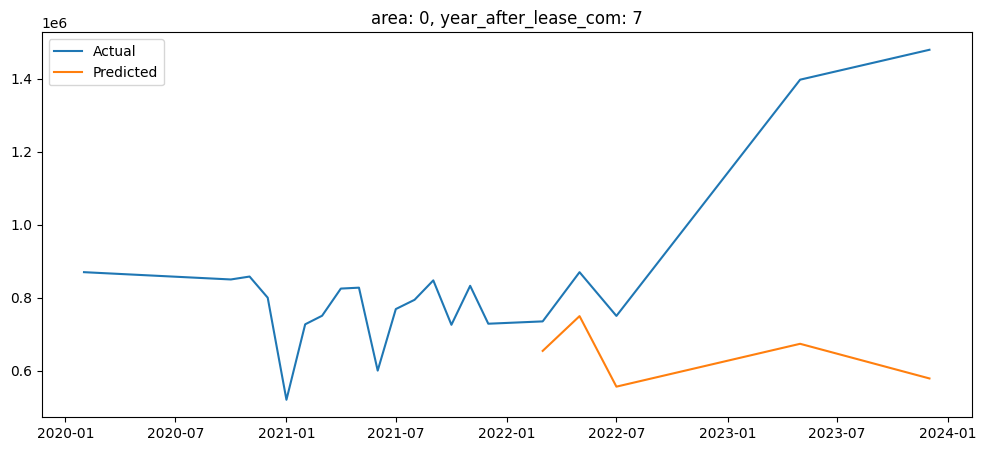

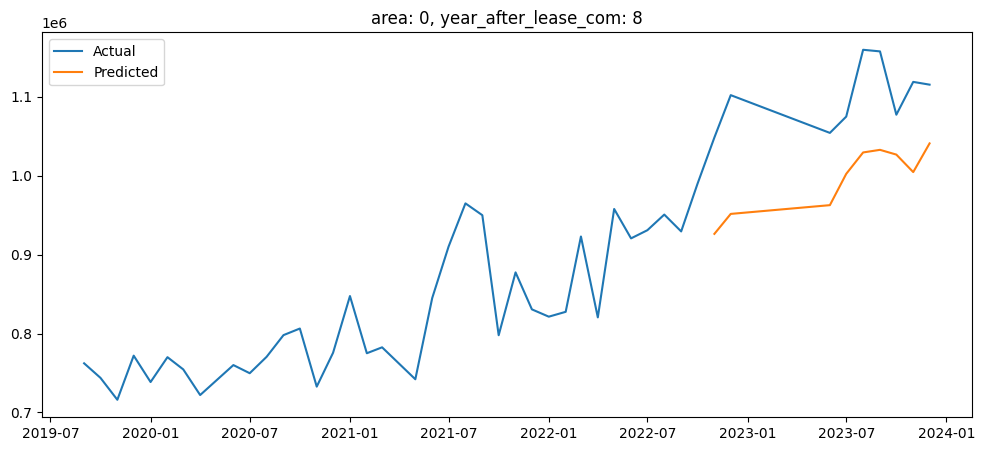

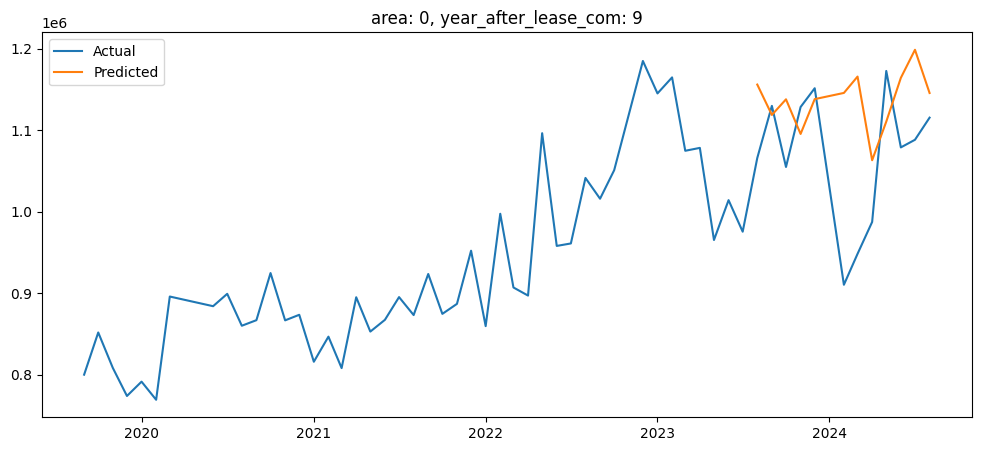

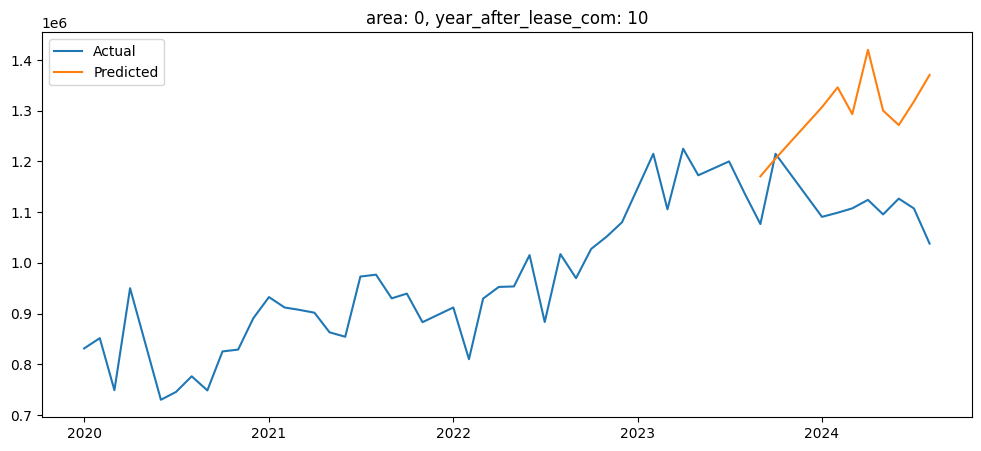

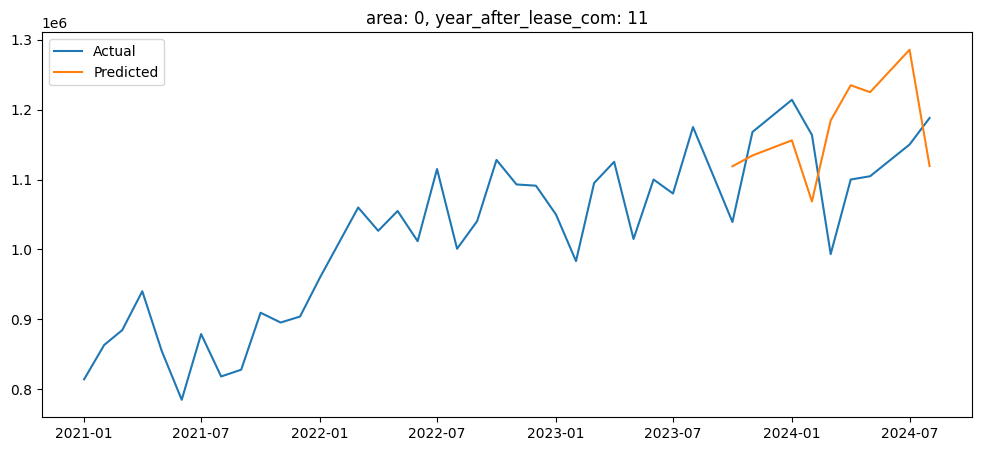

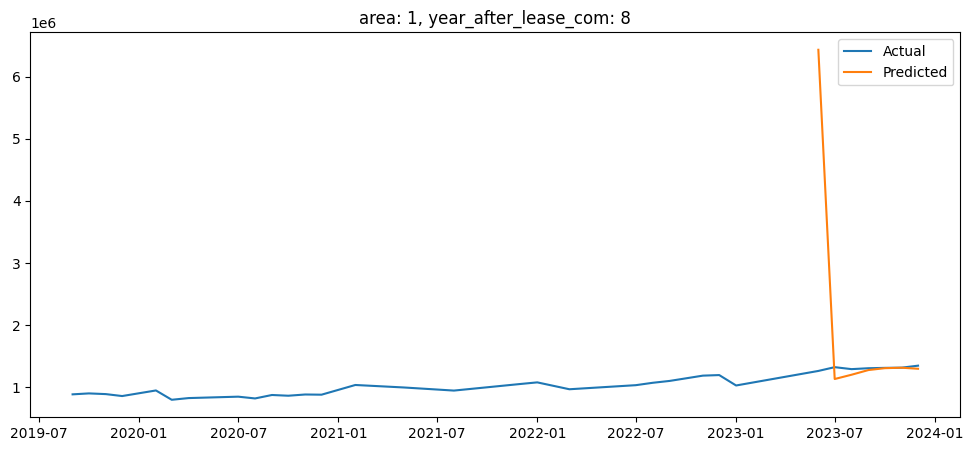

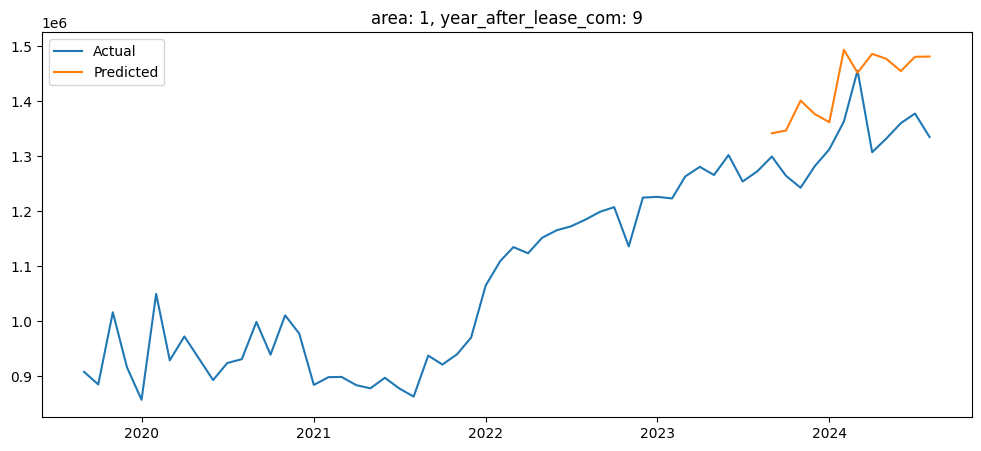

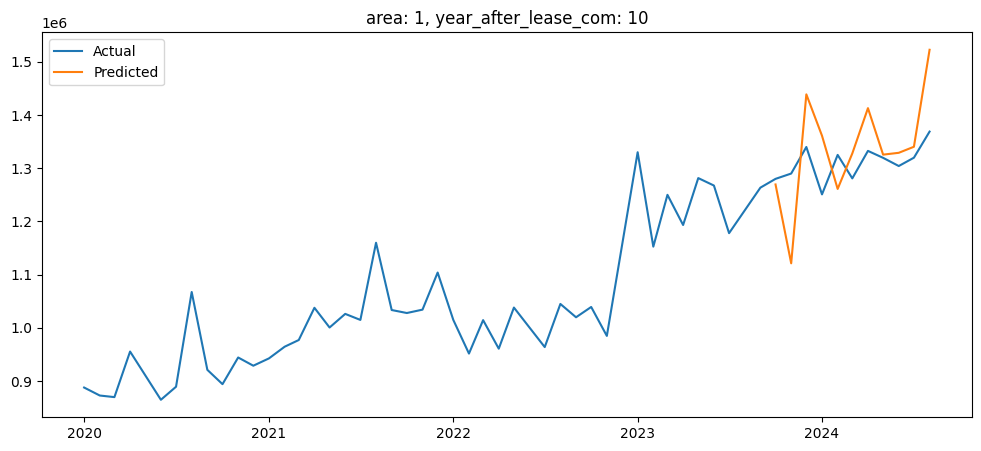

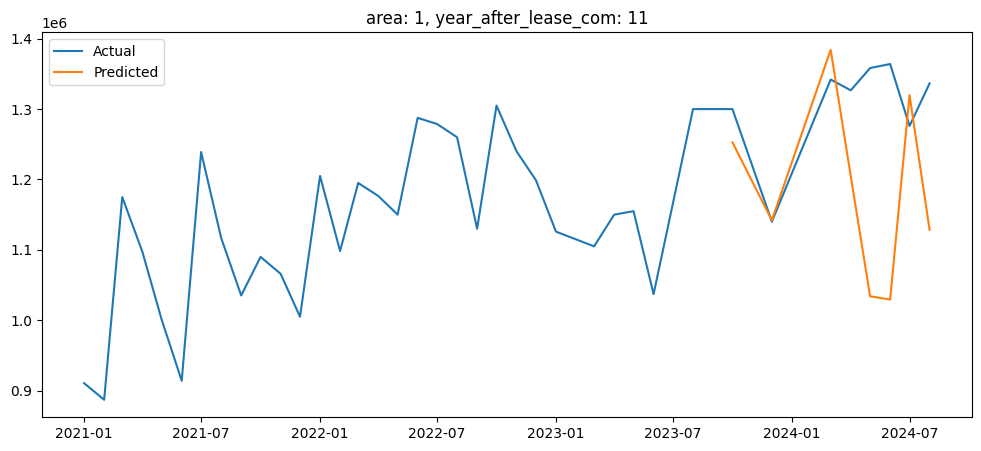

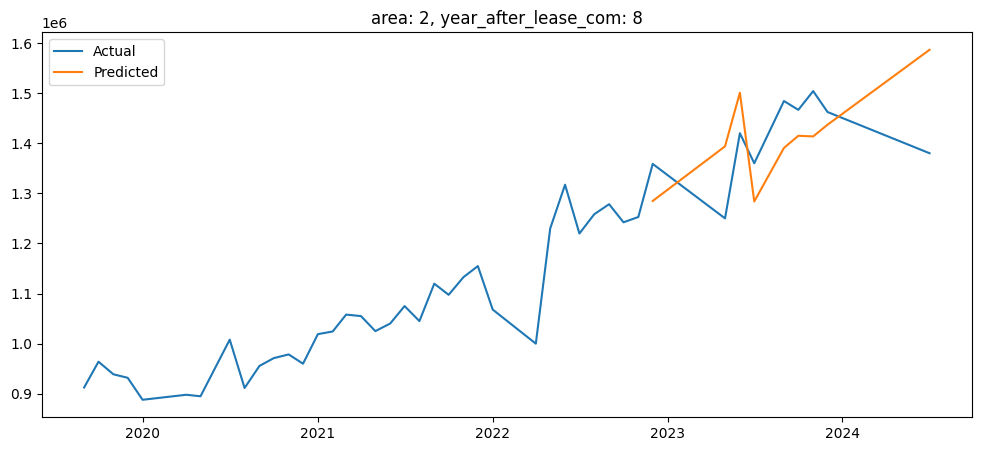

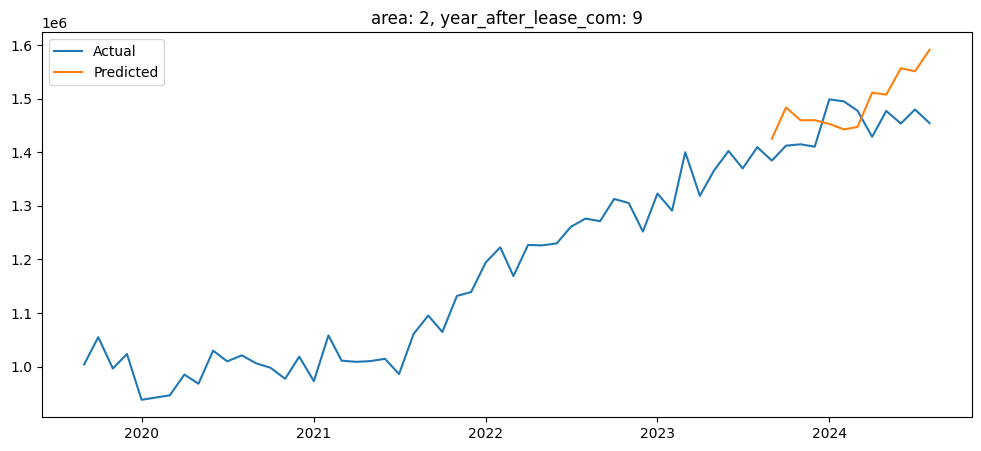

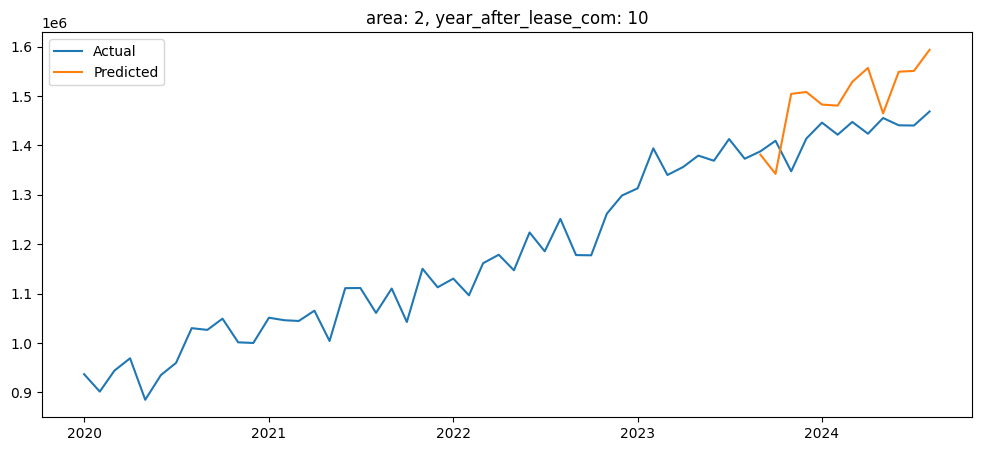

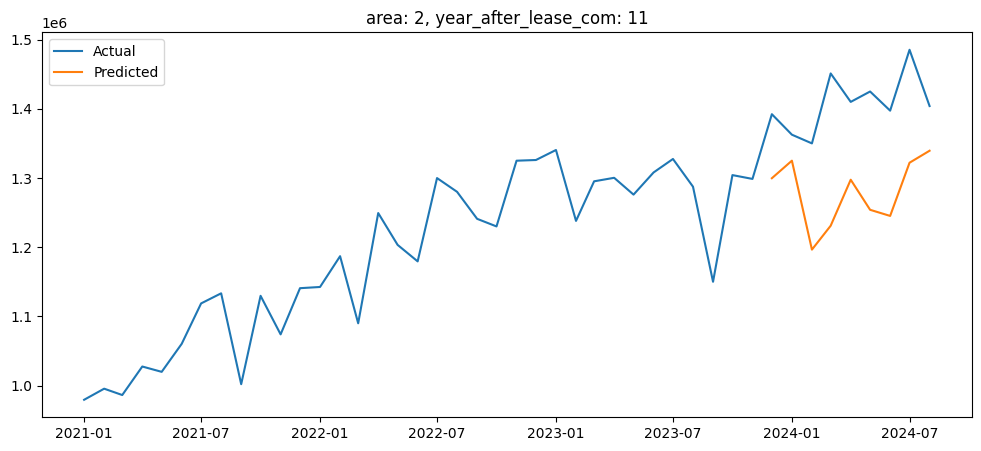

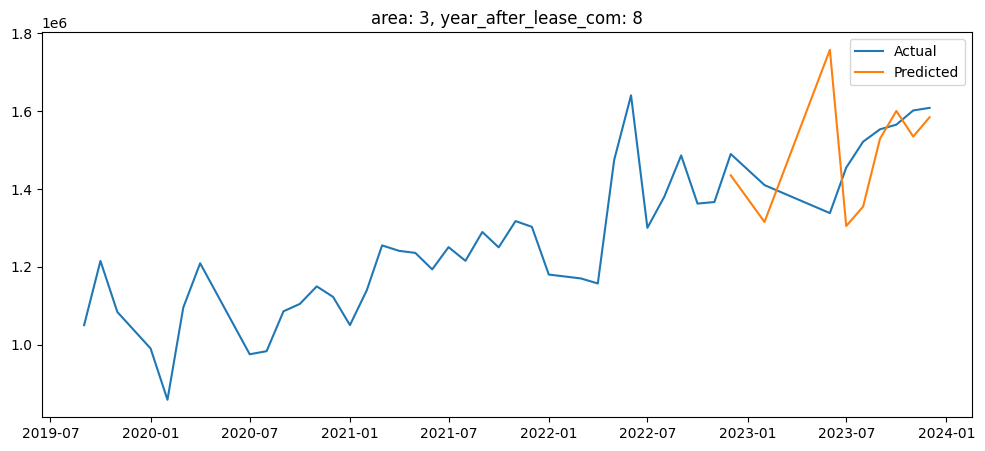

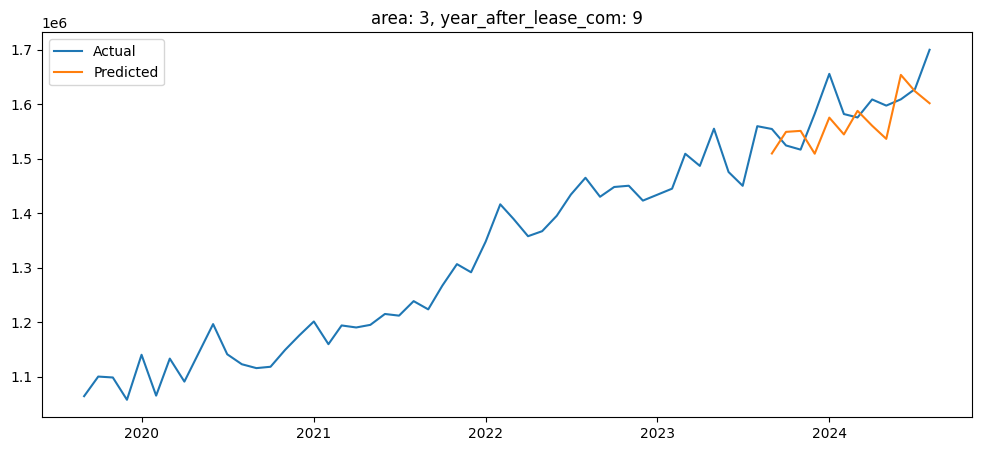

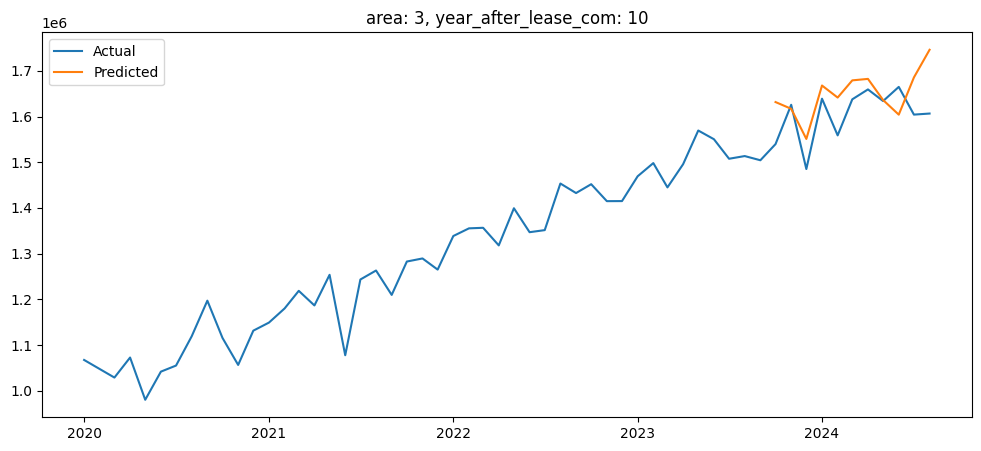

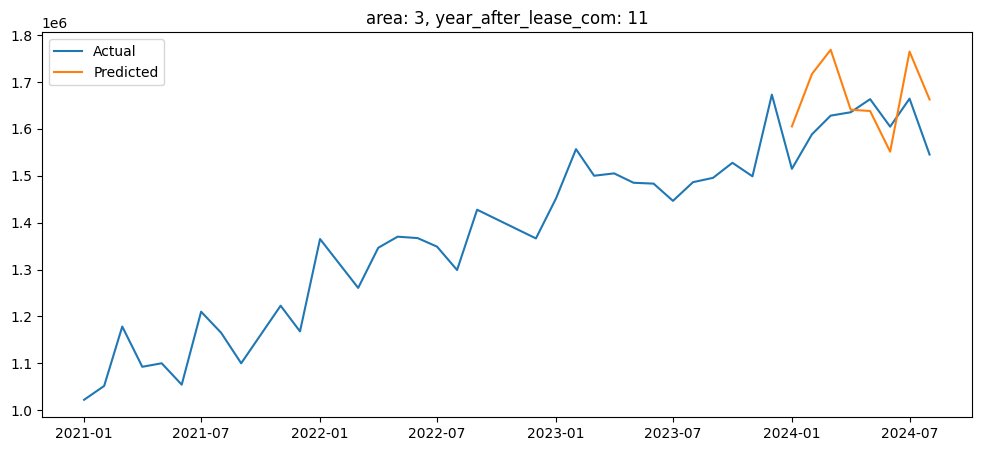

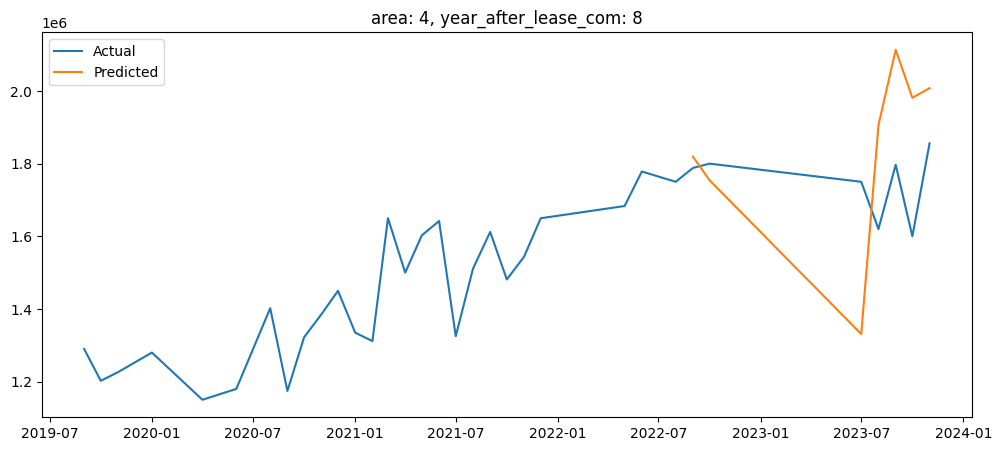

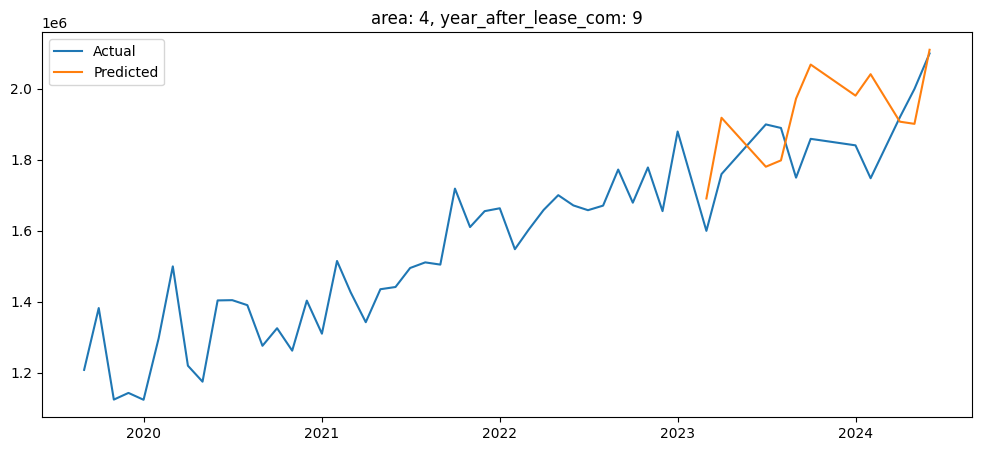

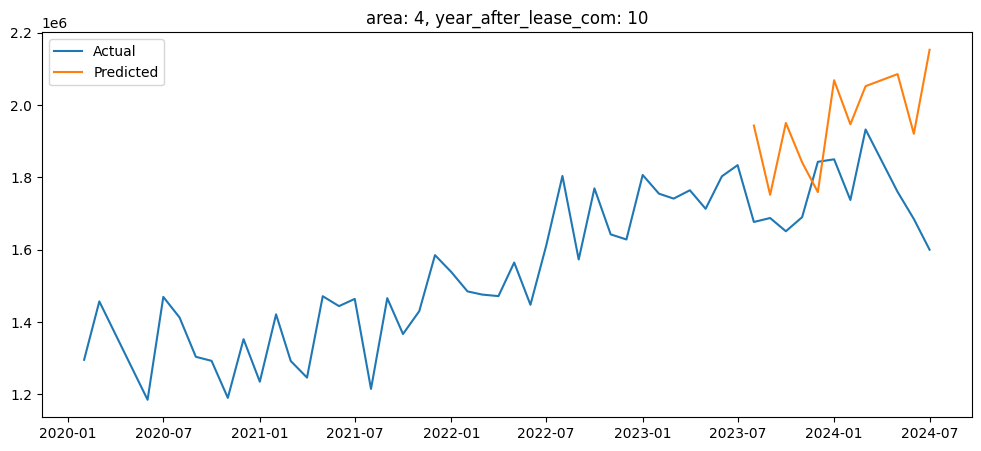

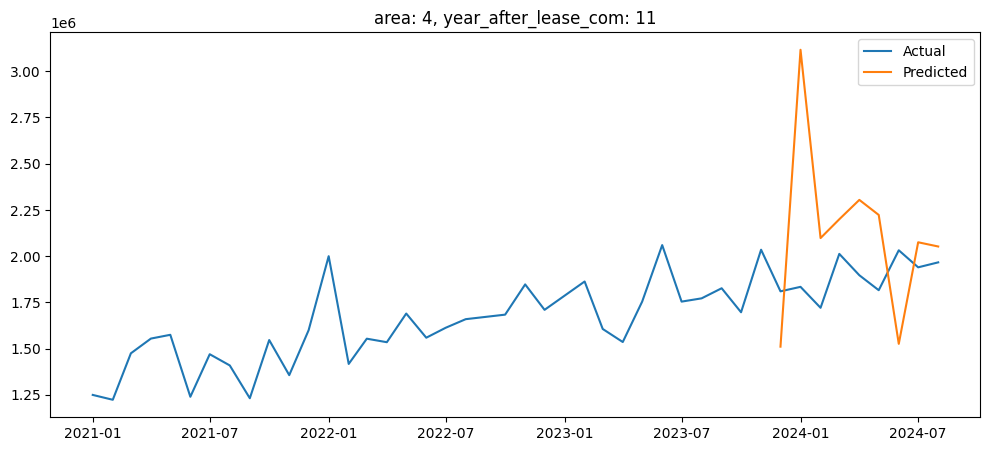

In [19]:
area_list = sorted(df['area'].unique())#[0:50] #for testing
year_after_lease_com_list = sorted(df['year_after_lease_com'].unique())

# Define the parameters for the Prophet model
seasonality = {
    'yearly': True,
    'weekly': False,
    'daily': False
}
start = time.time()
predictions = []
train_data = []
test_data = []
train_indices = []
metric_list = []
#mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
#experiment_id = mlflow.set_experiment("ec-price-experiment")

for area in area_list:
    area = int(area)
    for year_after_lease_com in year_after_lease_com_list[5:11]:
        model_name = f'model_area{area}_year{year_after_lease_com}'
        model_path = f'../models/model_area{area}_year{year_after_lease_com}.json'
        fig_path = f'../reports/figures/model_area{area}_year{year_after_lease_com}.png'
        df_select = prep_ec_data(df, area=area,year_after_lease_com=year_after_lease_com)#[['ds','y']]
        if len(df_select)>20:
            print('start to train')
            with mlflow.start_run(experiment_id=exp_id):
                mlflow.autolog()
        
                predicted, df_train, df_test, forecaster, rmse, mae = train_predict(
                    df = df_select,
                    train_fraction = 0.8,
                    seasonality=seasonality,
                    model_path=model_path
                )
                fig, ax = plt.subplots(1,1,figsize=(12,5))
                plt.plot(df_select.ds,df_select.y.values, label='Actual')
                plt.plot(df_test.ds,predicted.loc[:, 'yhat'], label='Predicted')
                plt.title(f'area: {area}, year_after_lease_com: {year_after_lease_com}')
                plt.legend()
                plt.savefig(fig_path)
                #mlflow.log_figure(fig, f'predict_area{area}_year{year_after_lease_com}.png')
                #mlflow.log_metrics({'rmse':rmse})
                metric_list.append({'area':area,'year_after_lease_com':year_after_lease_com,'rmse':rmse,'mae':mae})

                tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
                if tracking_url_type_store != "file":
                    # Register the model
                    # There are other ways to use the Model Registry, which depends on the use case,
                    # please refer to the doc for more information:
                    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                    mlflow.prophet.log_model(forecaster, artifact_path="model")#, registered_model_name=model_name
                else:
                    mlflow.prophet.log_model(forecaster, "model")        


                #mlflow.prophet.log_model(forecaster, artifact_path="model")
                #mlflow.prophet.autolog(registered_model_name="<model name>")
                logging.info("Logged model")
                
                mlflow.log_params(seasonality)
                mlflow.log_metrics(
                    {
                        'rmse': mean_squared_error(y_true=df_test['y'], y_pred=forecaster.predict(df_test)['yhat'], squared=False),
                        'mean_abs_perc_error': mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecaster.predict(df_test)['yhat']),
                        'mean_abs_error': mean_absolute_error(y_true=df_test['y'], y_pred=forecaster.predict(df_test)['yhat']),
                        'median_abs_error': median_absolute_error(y_true=df_test['y'], y_pred=forecaster.predict(df_test)['yhat'])
                    }
                )
    else:
        print('not enough data')




df_metric = pd.DataFrame(metric_list)
df_metric.to_csv('../reports/testing_metric.csv')

In [12]:
area

4

In [13]:
year_after_lease_com

11

In [14]:
len(df_select)

42